# Vehicle Routing: Branch-and-Price vs Column Generation

This notebook compares two approaches for solving the Capacitated Vehicle Routing Problem (CVRP):

1. **Column Generation (CG)** - Solves LP relaxation with column generation, then rounds to integer
2. **Branch-and-Price (B&P)** - Full branch-and-bound tree with column generation at each node

## Problem Description

Given:
- A depot where all vehicles start and end
- $n$ customers with locations and demands $d_i$
- Vehicles with capacity $Q$

Find routes for vehicles to:
- Visit every customer exactly once (set partitioning)
- Respect vehicle capacity constraints
- Minimize total travel distance

## Why B&P for VRP?

VRP is harder than cutting stock because:
1. **Set Partitioning**: Each customer must be in *exactly one* route (equality constraints)
2. **Ryan-Foster Branching**: Standard variable branching doesn't work well
3. **Larger Integrality Gaps**: VRP LP relaxations are often more fractional

In [ ]:
# OpenCG should be installed as a package (pip install -e path/to/opencg or pip install opencg)
# OpenBP should also be installed (pip install -e path/to/openbp)

# If running from the openbp repo without installation, uncomment:
# import sys
# sys.path.insert(0, "../..")  # Add openbp root

In [2]:
# Import OpenCG for column generation
from opencg.applications.vrp import (
    CVRPInstance,
    CVRPConfig,
    solve_cvrp,
)

# Import OpenBP for branch-and-price
from openbp.solver import BranchAndPrice, BPConfig, BPStatus
from openbp.branching import RyanFosterBranching, VariableBranching
from openbp.selection import create_selector

import matplotlib.pyplot as plt
import numpy as np
import time

## Example 1: Small Instance

Let's start with a small instance to visualize the problem and solution.

In [3]:
# Create a simple instance
instance = CVRPInstance(
    depot=(50, 50),
    customers=[
        (20, 70),   # Customer 0: northwest
        (80, 70),   # Customer 1: northeast
        (80, 30),   # Customer 2: southeast
        (20, 30),   # Customer 3: southwest
        (50, 90),   # Customer 4: north
        (50, 10),   # Customer 5: south
    ],
    demands=[15, 20, 25, 10, 30, 20],  # Total: 120
    vehicle_capacity=50,
    name="small_vrp"
)

print(f"Instance: {instance.name}")
print(f"Depot: {instance.depot}")
print(f"Customers: {instance.num_customers}")
print(f"Total demand: {instance.total_demand}")
print(f"Vehicle capacity: {instance.vehicle_capacity}")
print(f"Min vehicles needed: {instance.min_vehicles}")
print()
print("Customers:")
for i in range(instance.num_customers):
    print(f"  {i}: location={instance.customers[i]}, demand={instance.demands[i]}")

Instance: small_vrp
Depot: (50, 50)
Customers: 6
Total demand: 120
Vehicle capacity: 50
Min vehicles needed: 3

Customers:
  0: location=(20, 70), demand=15
  1: location=(80, 70), demand=20
  2: location=(80, 30), demand=25
  3: location=(20, 30), demand=10
  4: location=(50, 90), demand=30
  5: location=(50, 10), demand=20


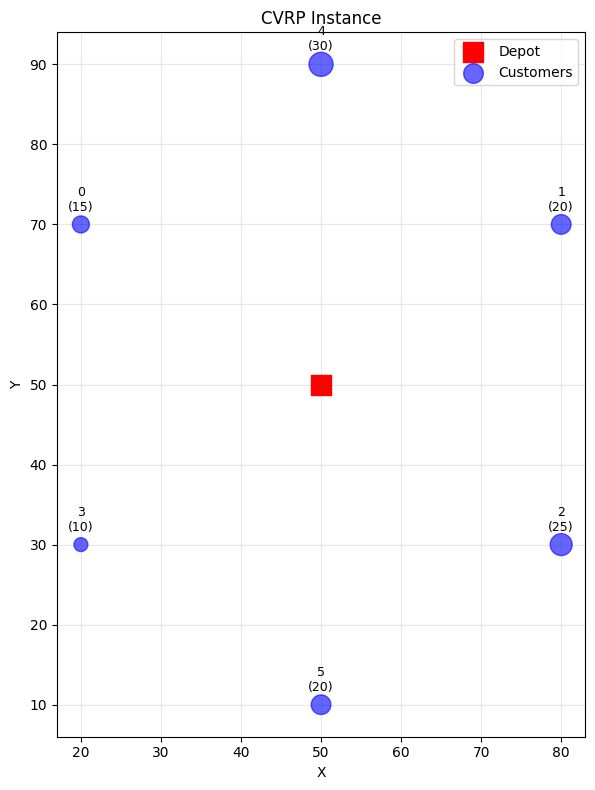

In [4]:
def visualize_instance(instance, title="CVRP Instance"):
    """Visualize customers and depot."""
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot depot
    ax.scatter(*instance.depot, s=200, c='red', marker='s', zorder=5, label='Depot')
    
    # Plot customers
    xs = [c[0] for c in instance.customers]
    ys = [c[1] for c in instance.customers]
    sizes = [d * 10 for d in instance.demands]
    
    ax.scatter(xs, ys, s=sizes, c='blue', alpha=0.6, zorder=4, label='Customers')
    
    # Label customers
    for i, (x, y) in enumerate(instance.customers):
        ax.annotate(f"{i}\n({instance.demands[i]})", (x, y), 
                   textcoords="offset points", xytext=(0, 10),
                   ha='center', fontsize=9)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

visualize_instance(instance)

### Approach 1: Column Generation Only

First, let's solve with OpenCG's column generation.

In [5]:
# Solve with column generation
config = CVRPConfig(verbose=True, max_iterations=50)
start = time.time()
cg_solution = solve_cvrp(instance, config)
cg_time = time.time() - start

print(f"\n" + "="*60)
print("COLUMN GENERATION RESULTS")
print("="*60)
print(f"LP relaxation: {cg_solution.total_distance:.2f}")
print(f"IP solution: {cg_solution.total_distance_ip:.2f}")
print(f"Vehicles used: {cg_solution.num_vehicles}")
print(f"Solve time: {cg_time:.3f}s")
print(f"CG iterations: {cg_solution.iterations}")
print(f"Columns generated: {cg_solution.num_columns}")
print()
print("Routes:")
for i, route in enumerate(cg_solution.routes):
    route_demand = sum(instance.demands[c] for c in route)
    print(f"  Route {i+1}: {route} (demand: {route_demand}/{instance.vehicle_capacity})")

Lower bound (capacity): 3 vehicles
Network: 9 nodes, 44 arcs
Greedy heuristic: 3 routes, cost=336.33
Using C++ backend: True

Column Generation:
 Iter    Objective  Columns   New
-----------------------------------
Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
LP has 6 rows; 9 cols; 12 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [1e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [1e+00, 1e+00]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-6); columns 0(-9); nonzeros 0(-12) - Reduced to empty
Performed postsolve
Solving the original LP from the solution after postsolve

Model status        : Optimal
Objective value     :  3.3633307653e+02
P-D objective error :  4.6746083214e-14
HiGHS run time      :          0.00
    0       336.33        9     5
LP has 6 rows; 14 cols; 19 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [7e+01, 1e+06]
  Bound   [0

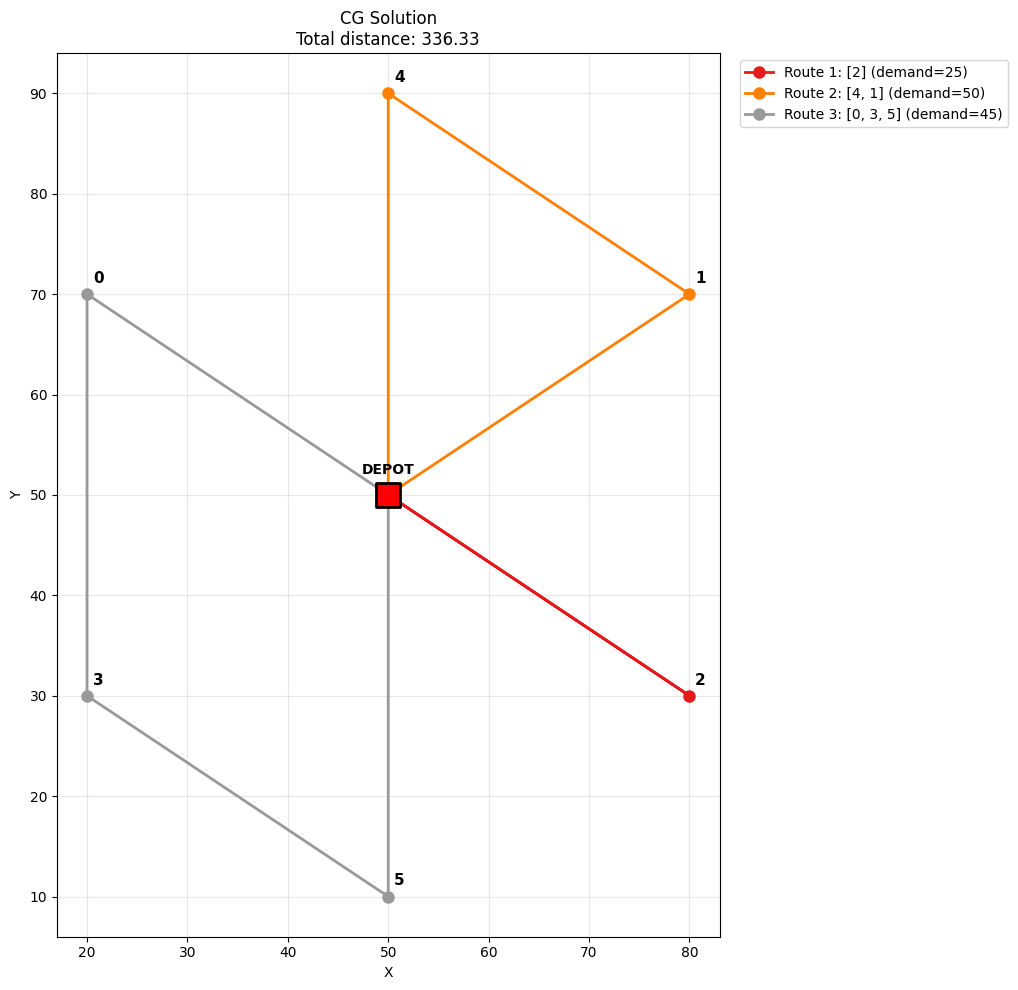

In [6]:
def visualize_solution(instance, routes, title="CVRP Solution", total_cost=None):
    """Visualize routes on the map."""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    colors = plt.cm.Set1(np.linspace(0, 1, max(len(routes), 1)))
    
    # Plot routes
    for idx, route in enumerate(routes):
        if not route:
            continue
        
        # Build path: depot -> customers -> depot
        path_x = [instance.depot[0]]
        path_y = [instance.depot[1]]
        
        for cust in route:
            path_x.append(instance.customers[cust][0])
            path_y.append(instance.customers[cust][1])
        
        path_x.append(instance.depot[0])
        path_y.append(instance.depot[1])
        
        route_demand = sum(instance.demands[c] for c in route)
        ax.plot(path_x, path_y, 'o-', color=colors[idx], linewidth=2, markersize=8,
               label=f'Route {idx+1}: {route} (demand={route_demand})')
    
    # Plot depot
    ax.scatter(*instance.depot, s=300, c='red', marker='s', zorder=10, 
               edgecolors='black', linewidth=2)
    ax.annotate('DEPOT', instance.depot, textcoords="offset points", xytext=(0, 15),
               ha='center', fontsize=10, fontweight='bold')
    
    # Label customers
    for i, (x, y) in enumerate(instance.customers):
        ax.annotate(f"{i}", (x, y), textcoords="offset points", xytext=(8, 8),
                   ha='center', fontsize=11, fontweight='bold')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    title_str = title
    if total_cost is not None:
        title_str += f"\nTotal distance: {total_cost:.2f}"
    ax.set_title(title_str)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

visualize_solution(instance, cg_solution.routes, "CG Solution", cg_solution.total_distance_ip)

### About Branch-and-Price for VRP

For VRP, standard variable branching often performs poorly because:

1. **Symmetry**: Many equivalent routes exist
2. **Weak Bounds**: Forcing a variable to 0/1 may not tighten the LP much

**Ryan-Foster Branching** is the preferred approach:
- Branch on pairs of customers $(i, j)$
- Left branch: $i$ and $j$ must be in the **same** route
- Right branch: $i$ and $j$ must be in **different** routes

This is implemented in OpenBP's `RyanFosterBranching` strategy.

## Example 2: Instance with Integrality Gap

Let's create an instance where the LP relaxation is more fractional.

Instance: gap_instance
Customers: 10
Total demand: 223
Vehicle capacity: 80
Min vehicles: 3


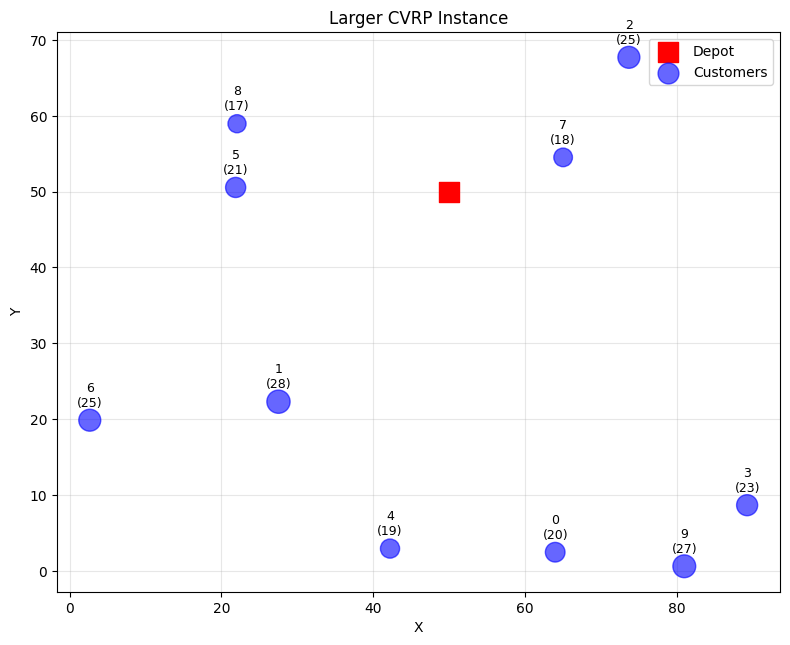

In [7]:
import random

# Generate instance designed to have integrality gap
random.seed(42)
n_customers = 10

customers = [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(n_customers)]
demands = [random.randint(15, 35) for _ in range(n_customers)]

instance2 = CVRPInstance(
    depot=(50, 50),
    customers=customers,
    demands=demands,
    vehicle_capacity=80,
    name="gap_instance"
)

print(f"Instance: {instance2.name}")
print(f"Customers: {instance2.num_customers}")
print(f"Total demand: {instance2.total_demand}")
print(f"Vehicle capacity: {instance2.vehicle_capacity}")
print(f"Min vehicles: {instance2.min_vehicles}")

visualize_instance(instance2, "Larger CVRP Instance")

In [8]:
# Solve with CG
config = CVRPConfig(verbose=True, max_iterations=100)
start = time.time()
cg_sol2 = solve_cvrp(instance2, config)
cg_time2 = time.time() - start

print(f"\n" + "="*60)
print("CG RESULTS")
print("="*60)
print(f"LP: {cg_sol2.total_distance:.2f}")
print(f"IP: {cg_sol2.total_distance_ip:.2f}")
print(f"Integrality gap: {100*(cg_sol2.total_distance_ip - cg_sol2.total_distance)/cg_sol2.total_distance:.2f}%")
print(f"Vehicles: {cg_sol2.num_vehicles}")
print(f"Time: {cg_time2:.3f}s")

Lower bound (capacity): 3 vehicles
Network: 13 nodes, 112 arcs
Greedy heuristic: 3 routes, cost=463.98
Using C++ backend: True

Column Generation:
 Iter    Objective  Columns   New
-----------------------------------
Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
LP has 10 rows; 13 cols; 20 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [1e+02, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [1e+00, 1e+00]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-10); columns 0(-13); nonzeros 0(-20) - Reduced to empty
Performed postsolve
    0       463.98       13 Solving the original LP from the solution after postsolve

Model status        : Optimal
Objective value     :  4.6397869796e+02
P-D objective error :  2.3631792438e-13
HiGHS run time      :          0.00
   68
LP has 10 rows; 81 cols; 194 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [3e+01, 1e+06]
  Bo

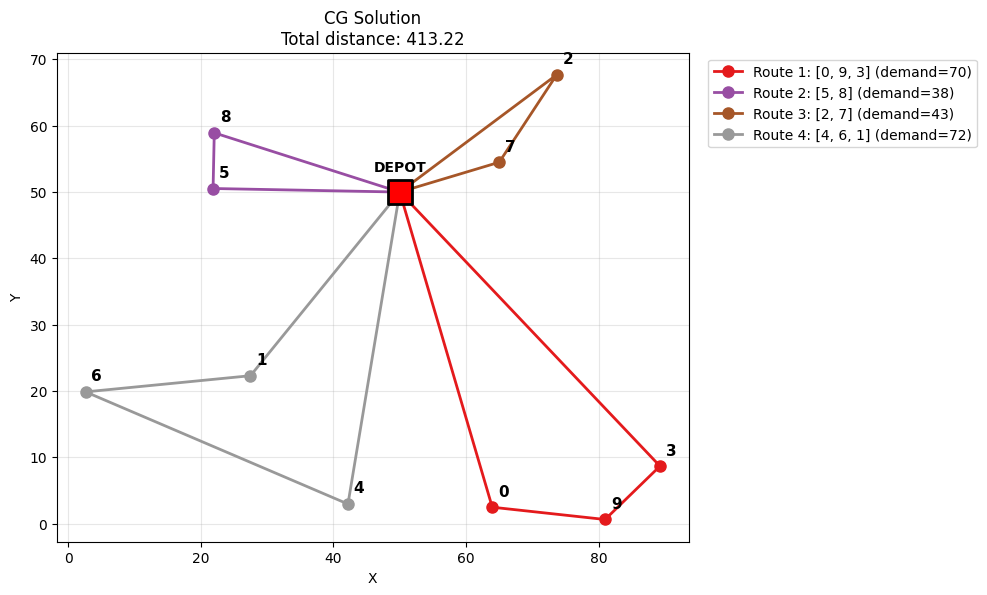

In [9]:
visualize_solution(instance2, cg_sol2.routes, "CG Solution", cg_sol2.total_distance_ip)

## Example 3: Loading Solomon Benchmark

Let's load a standard Solomon benchmark instance (used for VRPTW, we ignore time windows for CVRP).

In [ ]:
# Check for Solomon data using OpenCG's config
from opencg.config import get_data_path

solomon_path = get_data_path() / "solomon"
if solomon_path.exists():
    print(f"Solomon data found at: {solomon_path}")
    files = sorted(solomon_path.glob("*.txt"))[:10]
    for f in files:
        print(f"  {f.name}")
else:
    print(f"Solomon data not found at: {solomon_path}")
    print("Set OPENCG_DATA_PATH environment variable or configure opencg.config")

In [ ]:
# Load and solve a Solomon instance
if solomon_path.exists():
    # Load a smaller C-type instance (clustered customers)
    instance_file = solomon_path / "c101.txt"
    if instance_file.exists():
        solomon_instance = CVRPInstance.from_solomon(str(instance_file))
        
        # Take only first 15 customers for demo
        small_instance = CVRPInstance(
            depot=solomon_instance.depot,
            customers=solomon_instance.customers[:15],
            demands=solomon_instance.demands[:15],
            vehicle_capacity=solomon_instance.vehicle_capacity,
            name=f"{solomon_instance.name}_15"
        )
        
        print(f"Instance: {small_instance.name}")
        print(f"Customers: {small_instance.num_customers}")
        print(f"Total demand: {small_instance.total_demand}")
        print(f"Capacity: {small_instance.vehicle_capacity}")
        print(f"Min vehicles: {small_instance.min_vehicles}")
        
        # Solve
        config = CVRPConfig(verbose=True, max_iterations=100)
        solomon_sol = solve_cvrp(small_instance, config)
        
        print(f"\nSolution:")
        print(f"  LP: {solomon_sol.total_distance:.2f}")
        print(f"  IP: {solomon_sol.total_distance_ip:.2f}")
        print(f"  Vehicles: {solomon_sol.num_vehicles}")
        
        visualize_solution(small_instance, solomon_sol.routes, f"{small_instance.name} Solution", 
                          solomon_sol.total_distance_ip)

Instance: c101_15
Customers: 15
Total demand: 260.0
Capacity: 200.0
Min vehicles: 2
Lower bound (capacity): 2 vehicles
Network: 18 nodes, 242 arcs
Greedy heuristic: 2 routes, cost=197.25
Using C++ backend: True

Column Generation:
 Iter    Objective  Columns   New
-----------------------------------
Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
LP has 15 rows; 17 cols; 30 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [8e+01, 1e+06]
  Bound   [0e+00, 0e+00]
  RHS     [1e+00, 1e+00]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-15); columns 0(-17); nonzeros 0(-30) - Reduced to empty
Performed postsolve
Solving the original LP from the solution after postsolve

Model status        : Optimal
Objective value     :  1.9725231237e+02
P-D objective error :  1.1164463071e-12
HiGHS run time      :          0.00
    0       197.25       17 

## Understanding the Integrality Gap

The **integrality gap** is the difference between the LP relaxation and the optimal integer solution.

For VRP:
- LP can assign fractional routes (e.g., use route A 0.5 times and route B 0.5 times)
- IP must use integer routes
- The gap can be significant for clustered or constrained instances

**Branch-and-Price** closes this gap by:
1. Branching on Ryan-Foster decisions
2. Adding constraints that eliminate fractional solutions
3. Proving optimality when the tree is exhausted

In [ ]:
# Analyze integrality gaps across instances
print("Integrality Gap Analysis")
print("="*60)
print(f"{'Instance':<20} {'LP':<12} {'IP':<12} {'Gap %':<10}")
print("-"*60)

results = [
    ("small_vrp", cg_solution.total_distance, cg_solution.total_distance_ip),
    ("gap_instance", cg_sol2.total_distance, cg_sol2.total_distance_ip),
]

if 'solomon_sol' in dir():
    results.append(("c101_15", solomon_sol.total_distance, solomon_sol.total_distance_ip))

for name, lp, ip in results:
    gap = 100 * (ip - lp) / lp if lp > 0 else 0
    print(f"{name:<20} {lp:<12.2f} {ip:<12.2f} {gap:<10.2f}")

## Summary

### Key Insights for VRP

1. **Column Generation Works Well**: The LP relaxation often gives good bounds quickly
2. **IP Rounding Can Be Optimal**: For many instances, the LP solution rounds to optimal
3. **Larger Gaps Exist**: Some instances have significant integrality gaps
4. **B&P is Essential for Provable Optimality**: When you need guaranteed optimal solutions

### VRP vs Cutting Stock

| Aspect | Cutting Stock | VRP |
|--------|---------------|-----|
| Constraints | Covering (≥) | Partitioning (=) |
| Branching | Variable | Ryan-Foster |
| Integrality Gaps | Usually small | Can be larger |
| Optimal IP from LP | Very common | Often, but not always |

### When to Use B&P for VRP

- Need proven optimal solutions
- Have time budget for exploration
- Instance size is moderate (< 100 customers typically)
- Research/benchmarking context